# Imports

In [10]:
import importlib
import SYT 
import matplotlib.pyplot as plt

importlib.reload(SYT)

c:\Users\ptwel\OneDrive\Desktop\Math-480-master\syt_6_20_2024_SYT


<module 'SYT' from 'c:\\Users\\ptwel\\OneDrive\\Desktop\\Math-480-master\\syt_6_20_2024_SYT\\SYT.py'>

## SYT Helper Functions.
Implement the functions `is_valid_SYT` and `reshape_perm` then run this cell to test your helper functions. 

In [11]:
print(SYT.is_valid_SYT(((1, 2, 3), (4, 5, 6), (7, 8, 9)))) # True
print(SYT.is_valid_SYT(((1, 2, 3), (5, 4), (6,)))) # False

print(SYT.reshape_perm((1, 2, 3, 4, 5, 6), (3, 2, 1))) # ((1, 2, 3), (4, 5), (6,))
print(SYT.reshape_perm((1, 2, 3, 4, 5, 6), (3, 3))) # ((1, 2, 3), (4, 5, 6))

True
False
((1, 2, 3), (4, 5), (6,))
((1, 2, 3), (4, 5, 6))


# Generate all SYTs
Implement `SYTs` and generate all valid SYTs for the following shapes:
- (4,3,2,1)
- (2,2)
- (3,3)
- (4,4)
- (5,5)

Save your SYTs in the `data` subfolder. For example, the SYTs of shape (4,3,2,1) are saved in `data/SYTs_4_3_2_1.txt`.

What do you notice about SYTs of shape (n,n)? Write your observation in this cell here:


In [ ]:
"For each SYT of shape (n,n) the number of unique SYTs are the number of the nth catalan number"

# Generate SYTs
shapes = [(4,3,2,1), (2,2), (3,3), (4,4), (5,5)]
SYT.generate_all_SYTs(shapes)

# Generating Random SYTs
Implement `random_SYT` and `random_SYT_2` and compare the efficacy on the shape (2,2,2).

Print out how long it takes to generate 10000 samples using each function and compare the distributions to the uniform distribution.

Plot the distributions using matplotlib and save them in the `figures` subfolder.

Distribution for random_SYT:
((1, 2), (3, 4), (5, 6)): 1959
((1, 2), (3, 5), (4, 6)): 2073
((1, 3), (2, 4), (5, 6)): 1984
((1, 3), (2, 5), (4, 6)): 1968
((1, 4), (2, 5), (3, 6)): 2016

Distribution for random_SYT2:
((1, 2), (3, 4), (5, 6)): 2002
((1, 2), (3, 5), (4, 6)): 1988
((1, 3), (2, 4), (5, 6)): 2082
((1, 3), (2, 5), (4, 6)): 1959
((1, 4), (2, 5), (3, 6)): 1969

Time taken to generate 10000 samples using random_SYT: 8.91126298904419 seconds
Time taken to generate 10000 samples using random_SYT2: 8.176995992660522 seconds


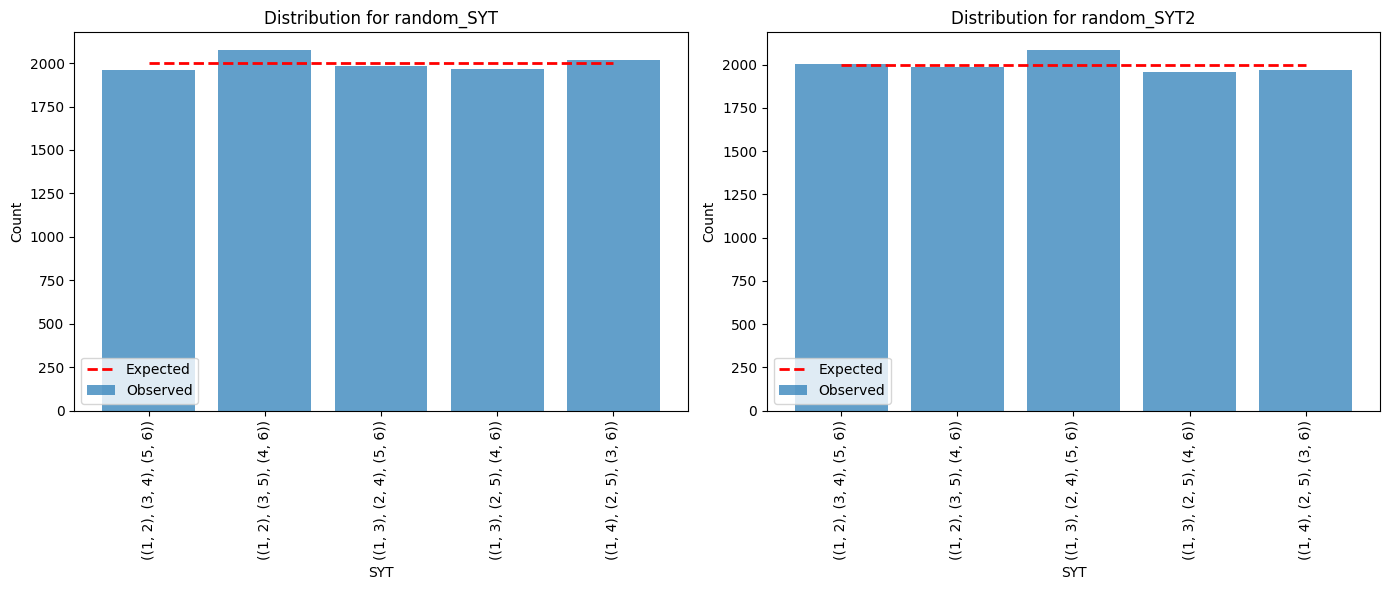

In [27]:
import time
import os

shape = (2, 2, 2)

# Pass the shape as a list containing a single tuple
all_syts = SYT.generate_all_SYTs([shape])
valid_syts = all_syts["_".join(map(str, shape))]
total_valid_syts = len(valid_syts)

distribution = {syt: 0 for syt in all_syts["_".join(map(str, shape))]}
distribution2 = {syt: 0 for syt in all_syts["_".join(map(str, shape))]}

# Calculate the expected uniform distribution


# Measure time for random_SYT
start_time = time.time()
for _ in range(10000):
    syt = SYT.random_SYT(shape)
    distribution[syt] += 1
end_time = time.time()
random_SYT_time = end_time - start_time

# Measure time for random_SYT2 (assuming it is defined similarly)
start_time = time.time()
for _ in range(10000):
    syt = SYT.random_SYT2(shape)  # Replace with random_SYT_2(shape) if defined
    distribution2[syt] += 1
end_time = time.time()
random_SYT_2_time = end_time - start_time


# Print the distributions
print("Distribution for random_SYT:")
for syt, count in distribution.items():
    print(f"{syt}: {count}")

print("\nDistribution for random_SYT2:")
for syt, count in distribution2.items():
    print(f"{syt}: {count}")

# Print the timing results
print(f"\nTime taken to generate 10000 samples using random_SYT: {random_SYT_time} seconds")
print(f"Time taken to generate 10000 samples using random_SYT2: {random_SYT_2_time} seconds")


figures_dir = "figures"
os.makedirs(figures_dir, exist_ok=True)

# Plot the distributions
syts = list(distribution.keys())
counts1 = [distribution[syt] for syt in syts]
counts2 = [distribution2[syt] for syt in syts]
expected_counts = [expected_count] * len(syts)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(range(len(syts)), counts1, tick_label=[str(syt) for syt in syts], alpha=0.7, label='Observed')
plt.plot(range(len(syts)), expected_counts, color='red', linestyle='dashed', linewidth=2, label='Expected')
plt.xticks(rotation=90)
plt.title('Distribution for random_SYT')
plt.xlabel('SYT')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(len(syts)), counts2, tick_label=[str(syt) for syt in syts], alpha=0.7, label='Observed')
plt.plot(range(len(syts)), expected_counts, color='red', linestyle='dashed', linewidth=2, label='Expected')
plt.xticks(rotation=90)
plt.title('Distribution for random_SYT2')
plt.xlabel('SYT')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'SYT_distributions.png'))
plt.show()